# Uplift Modeling to predict and target the right customers
![](https://st2.ning.com/topology/rest/1.0/file/get/2220280883?profile=original)
[Uplift modelling](https://en.wikipedia.org/wiki/Uplift_modelling), also known as incremental modelling, true lift modelling, or net modelling is a predictive modelling technique that directly models the incremental impact of a treatment (such as a direct marketing action) on an individual's behaviour.

# Setup

In [1]:
# Import libraries
import numpy as np, matplotlib as mpl, matplotlib.pyplot as plt, pandas as pd
import seaborn as sns, math, os, warnings 
warnings.filterwarnings('ignore')
# Get file's directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/customer-retention/data.csv


# Data Exploration

In [2]:
# Import data
df_data = pd.read_csv('/kaggle/input/customer-retention/data.csv')
df_model = df_data.copy()

In [3]:
# Let's take a look at our data
df_model.head(5)

,recency,history,used_discount,used_bogo,zip_code,is_referral,channel,offer,conversion
0,10,142.44,1,0,Surburban,0,Phone,Buy One Get One,0
1,6,329.08,1,1,Rural,1,Web,No Offer,0
2,7,180.65,0,1,Surburban,1,Web,Buy One Get One,0
3,9,675.83,1,0,Rural,1,Web,Discount,0
4,2,45.34,1,0,Urban,0,Web,Buy One Get One,0


In [4]:
# Checking for null data
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 9 columns):
recency          64000 non-null int64
history          64000 non-null float64
used_discount    64000 non-null int64
used_bogo        64000 non-null int64
zip_code         64000 non-null object
is_referral      64000 non-null int64
channel          64000 non-null object
offer            64000 non-null object
conversion       64000 non-null int64
dtypes: float64(1), int64(5), object(3)
memory usage: 4.4+ MB


Good, there is no null data in this dataset

In [5]:
# Checking for object data
df_model.describe(include=np.object)

,zip_code,channel,offer
count,64000,64000,64000
unique,3,3,3
top,Surburban,Web,Buy One Get One
freq,28776,28217,21387


In [6]:
# Checking unique object data
object_cols = [col for col in df_model.columns if df_model[col].dtype == "object"]
for obj in object_cols:
    print('\n', obj)
    for unique in df_model[obj].unique():
        print("{} {}".format(unique,sum(df_model[obj] == unique)))


 zip_code
Surburban 28776
Rural 9563
Urban 25661

 channel
Phone 28021
Web 28217
Multichannel 7762

 offer
Buy One Get One 21387
No Offer 21306
Discount 21307


## Data Preprocessing

In [7]:
# Rename target column
df_model = df_model.rename(columns={'conversion': 'target'})
# Rename & Label encode treatment column
df_model = df_model.rename(columns={'offer': 'treatment'})
df_model.treatment = df_model.treatment.map({'No Offer': 0, 'Buy One Get One': -1, 'Discount': 1})

In [8]:
# One-Hot Encoding:
df_model = pd.get_dummies(df_model)

In [9]:
# Split data with bogo and discount
df_model_bogo = df_model.copy().loc[df_model.treatment <=0].reset_index(drop=True)
df_model_discount = df_model.copy().loc[df_model.treatment >=0].reset_index(drop=True)

## Target Class Declaration
* <h3> Control Non-Responders(CN) </h3>
Customers that don't make a purchase without an offer (value = 0) 
* <h3> Control Responders(CR) </h3>
Customers that make a purchase without an offer  (value = 1) 
* <h3> Treatment Non-Responders(TN) </h3>
Customer that don't make a purchase and receive an offer  (value = 2) 
* <h3> Treatment Responders(TR) </h3>
Customers that make a purchase and receive an offer (value = 3) 

In [10]:
# Function to declare Target Class
def declare_tc(df:pd.DataFrame):
    """Declare target class
    """
    #CN:
    df['target_class'] = 0 
    #CR:
    df.loc[(df.treatment == 0) & (df.target != 0),'target_class'] = 1 
    #TN:
    df.loc[(df.treatment != 0) & (df.target == 0),'target_class'] = 2 
    #TR:
    df.loc[(df.treatment != 0) & (df.target != 0),'target_class'] = 3 
    return df

In [11]:
# run the functions for each treatment
df_model_bogo = declare_tc(df_model_bogo)
df_model_discount = declare_tc(df_model_discount)

## Uplift Modeling
The Uplift model in this notebook use Lai’s Generalized Weighed Uplift (LGWUM) to calculate the uplift score.
<br>LGWUM is one of [several strategies or methods](https://www.worldscientific.com/doi/abs/10.1142/S0219622019500172) available for Uplift Modeling, that was introduced in [2002 by Lo](https://dl.acm.org/doi/abs/10.1145/772862.772872). Where P Denotes a Probabilty Score, T denotes the total treated population (TR + TN), and C denotes the total untreated population (CR + CN).
Thus, Uplift Score can be calculated as:
> **Uplift Score = P(TR)/P(T) + P(CN)/P(C) - P(TN)/P(T) - P(CR)/P(C)**

Moreover, XGBoost classifier will be used to build the model in this notebook.

In [12]:
# Functions for Uplift
from sklearn.model_selection import train_test_split
import xgboost as xgb
def uplift_split(df_model:pd.DataFrame):
    """Train-Test Split
    """
    X = df_model.drop(['target','target_class'],axis=1)
    y = df_model.target_class
    X_train, X_test, \
    y_train, y_test  = train_test_split(X,
                                       y,
                                       test_size=0.3,
                                       random_state=42,
                                       stratify=df_model['treatment'])
    return X_train,X_test, y_train, y_test


def uplift_model(X_train:pd.DataFrame,
                 X_test:pd.DataFrame,
                 y_train:pd.DataFrame,
                 y_test:pd.DataFrame):
    """Using XGB to get the uplift score
    """
    # Create new dataframe
    result = pd.DataFrame(X_test).copy()    
    # Fit the model
    uplift_model \
    = xgb.XGBClassifier().fit(X_train.drop('treatment', axis=1), y_train)
    
    
    # Predict using test-data
    uplift_proba \
    = uplift_model.predict_proba(X_test.drop('treatment', axis=1))
    result['proba_CN'] = uplift_proba[:,0] 
    result['proba_CR'] = uplift_proba[:,1] 
    result['proba_TN'] = uplift_proba[:,2] 
    result['proba_TR'] = uplift_proba[:,3]
    result['uplift_score'] = result.eval('\
    proba_CN/(proba_CN+proba_CR) \
    + proba_TR/(proba_TN+proba_TR) \
    - proba_TN/(proba_TN+proba_TR) \
    - proba_CR/(proba_CN+proba_CR)')  
    # Put the result 
    result['target_class'] = y_test
    return result


def uplift(df_model:pd.DataFrame):
    """Combine the split and Modeling function
    """
    X_train, X_test, y_train, y_test = uplift_split(df_model)
    result = uplift_model(X_train, X_test, y_train, y_test)
    return result

In [13]:
# Run the uplift function
bogo_uplift = uplift(df_model_bogo)
discount_uplift = uplift(df_model_discount)

# Evaluation - QINI Curve
Qini is a generalization of gini curve for Uplift model, introduced by [Radcliffe](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwj_lZbfkNHoAhU_8XMBHYMBBUAQFjAAegQICBAC&url=https%3A%2F%2Fwww.semanticscholar.org%2Fpaper%2FUsing-control-groups-to-target-on-predicted-lift%253A-Radcliffe%2F147b32f3d56566c8654a9999c5477dded233328e&usg=AOvVaw3FuLoBYIejr_plj6oAE27o). The QINI (Uplift value) can be calculated as: 
> **QINI = TR - [(CR*T)/C]**

Thus can be normalized in percentage as: 
> **QINI = (TR/T) - (CR/C)**

In [14]:
# Functions to build the Uplift model and visualize the QINI Curve
def qini_rank(uplift:pd.DataFrame):
    """Rank the data by the uplift score
    """
    # Creat new dataframe
    ranked = pd.DataFrame({'n':[], 'target_class':[]})
    ranked['target_class'] = uplift['target_class']
    ranked['uplift_score'] = uplift['uplift_score']
    
    
    # Add proportion
    ranked['n'] = ranked.uplift_score.rank(pct=True, ascending=False)
    # Data Ranking   
    ranked = ranked.sort_values(by='n').reset_index(drop=True)
    return ranked


def qini_eval(ranked:pd.DataFrame):
    """Evaluate the uplift value with the QINI criterion
    """
    uplift_model, random_model = ranked.copy(), ranked.copy()
    # Using Treatment and Control Group to calculate the uplift (Incremental gain)
    C, T = sum(ranked['target_class'] <= 1), sum(ranked['target_class'] >= 2)
    ranked['cr'] = 0
    ranked['tr'] = 0
    ranked.loc[ranked.target_class == 1,'cr'] = 1
    ranked.loc[ranked.target_class == 3,'tr'] = 1
    ranked['cr/c'] = ranked.cr.cumsum() / C
    ranked['tr/t'] = ranked.tr.cumsum() / T
    # Calculate and put the uplift and random value into dataframe
    uplift_model['uplift'] = round(ranked['tr/t'] - ranked['cr/c'],5)
    random_model['uplift'] = round(ranked['n'] * uplift_model['uplift'].iloc[-1],5)
    
    
    # Add q0
    q0 = pd.DataFrame({'n':0, 'uplift':0, 'target_class': None}, index =[0])
    uplift_model = pd.concat([q0, uplift_model]).reset_index(drop = True)
    random_model = pd.concat([q0, random_model]).reset_index(drop = True)  
    # Add model name & concat
    uplift_model['model'] = 'Uplift model'
    random_model['model'] = 'Random model'
    merged = pd.concat([uplift_model, random_model]).sort_values(by='n').reset_index(drop = True)
    return merged


def qini_plot(merged:pd.DataFrame):
    """Plot the QINI
    """
    # plot the data
    ax = sns.lineplot(x='n', y='uplift', hue='model', data=merged,
                      style='model', palette=['red','grey'])
    
    
    # Plot settings
    sns.set_style('whitegrid')
    handles, labels = ax.get_legend_handles_labels()
    plt.xlabel('Proportion targeted',fontsize=15)
    plt.ylabel('Uplift',fontsize=15)
    plt.subplots_adjust(right=1)
    plt.subplots_adjust(top=1)
    plt.legend(fontsize=12)
    ax.tick_params(labelsize=15)
    ax.legend(handles=handles[1:], labels=labels[1:], loc='upper right')
    return ax


def qini(uplift:pd.DataFrame):
    """Combine all functions
    """
    ranked = qini_rank(uplift)
    merged = qini_eval(ranked)
    ax = qini_plot(merged)
    return ax

# Result
The QINI curve as shown below visualize the performance of Uplift model in targeting the right customers from the test-data.
The results show that the Uplift model can give more uplift than random model (without model).

Text(0.5, 1.0, 'Qini Curve - Buy One Get One')

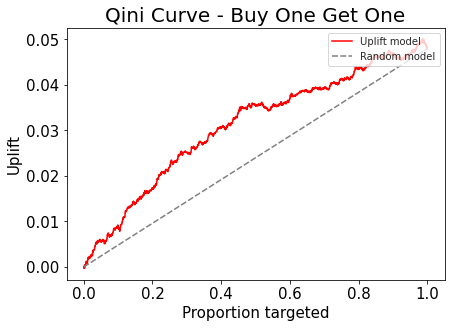

In [15]:
# plot the Qini curve for BOGO treatment
qini(bogo_uplift)
plt.title('Qini Curve - Buy One Get One',fontsize=20)

Text(0.5, 1.0, 'Qini Curve - Discount')

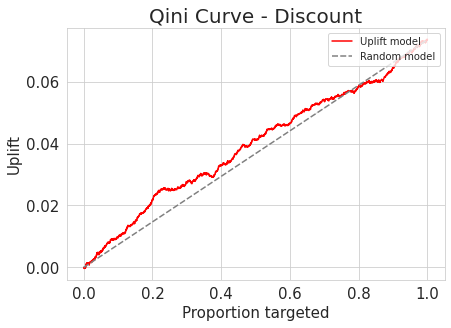

In [16]:
# plot the Qini curve for Discount treatment
qini(discount_uplift)
plt.title('Qini Curve - Discount',fontsize=20)